# Random Forest

In [1]:
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("expand_frame_repr", True)
pd.set_option("max_colwidth", None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

# ML FLOW
import mlflow
import subprocess
from pyngrok import ngrok

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

## 2. Import Data

### 2.1 Imbalanced Datasets

In [2]:
X_train = np.load("../notebook/data/Original/X_train.npy")
y_train = np.load("../notebook/data/Original/y_train.npy")
X_val = np.load("../notebook/data/Original/X_val.npy")
y_val = np.load("../notebook/data/Original/y_val.npy")

In [3]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((208480, 66), (208480,), (52121, 66), (52121,))

### 2.2 Undersampled Datasets

In [3]:
X_train_under_sample = np.load("../notebook/data/UnderSampling/X_train_undersample.npy")
y_train_under_sample = np.load("../notebook/data/UnderSampling/y_train_undersample.npy")

### 2.3 Oversampled Datasets

In [4]:
X_train_over_sample = np.load("../notebook/data/OverSampling/X_train_oversample.npy")
y_train_over_sample = np.load("../notebook/data/OverSampling/y_train_oversample.npy")

### 2.4 SMOTE Datasets

In [5]:
X_train_smote = np.load("../notebook/data/SMOTE/X_train_smote.npy")
y_train_smote = np.load("../notebook/data/SMOTE/y_train_smote.npy")

In [6]:
def plot_confusion_matrix(true, predicted):
    """
    Generate the confusion matrix and classification report
    """
    cm = confusion_matrix(true, predicted)
    cr = classification_report(true, predicted)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                             index=['Actual:1','Actual:2','Actual:3'])
    # confusion matrix in heatmap
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print(cr) 
    f1_micro = f1_score(true, predicted, average='micro')
    return f1_micro

In [7]:
def evaluate_model(model):
    
    print("Evaluating Model")
    
    # Make predictions
    y_train_pred = model.predict(X_train_smote)
    y_val_pred = model.predict(X_val)
    
    # Calculate micro averaged f1-score
    f1_micro_train = f1_score(y_train_smote, y_train_pred, average='micro')
    f1_micro_val = f1_score(y_val, y_val_pred, average='micro')
    
    print("Finished Evaluating Model")
    
    return f1_micro_train, f1_micro_val, y_train_pred, y_val_pred

In [8]:
def grid_search_cv(estimator, X_train, y_train, param_grid):
    
    print("Performing GridSearchCv")
    
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print("Finished GridSearchCv")
    return best_params

In [9]:
def train_model(estimator,X, y, best_params, estimator_name, dataset_type):
    
    print("Training Model")
    
    best_estimator = estimator.set_params(**best_params)
    
    # start time
    start_time = time.time()
    
    best_estimator.fit(X, y)
    
    # end time
    end_time = time.time()
    
    duration = np.round(end_time-start_time, 2)
    
    f1_micro_train, f1_micro_val, _ , y_val_pred = evaluate_model(best_estimator)
    
    log_results(best_params, best_estimator, estimator_name, f1_micro_train, f1_micro_val, dataset_type, duration)
    
    print("Successfull")
    
    return y_val_pred

In [10]:
def log_results(best_params, estimator, estimator_name, f1_micro_train, f1_micro_val, dataset_type, duration):
    
    print("Logging Results")
    with mlflow.start_run(run_name=f"{estimator_name}{dataset_type}"):
        mlflow.log_metric("f1_micro_train", f1_micro_train)
        mlflow.log_metric("f1_micro_val", f1_micro_val)
        mlflow.log_metric("Train Duration", duration)
  
        # Set best params
        for param_name, param_value in best_params.items():
            mlflow.log_param(param_name, param_value) 
    print("Finished Logging Results")

In [11]:
def random_forest_model_fitting(X_train, y_train, dataset_type, grid_params):
    # Instantiating the model
    estimator = RandomForestClassifier()

    decision_tree_params = grid_params
    estimator_name = "random_forest"

    best_params = grid_search_cv(estimator,X_train, y_train, decision_tree_params)
    print(f"Best Params for {dataset_type}: {best_params}")

    y_val_pred = train_model(estimator, X_train, y_train, best_params, estimator_name, dataset_type)

    f1_micro_score = plot_confusion_matrix(y_val, y_val_pred)

    print(f"F1 Micro Averaged Score = {f1_micro_score}")
    return best_params

# Random Forest Classifier

## Experiment 1: Tuning `max_depth` parameter

### ` Random Forest on Imbalanced Dataset`

In [16]:
max_depth_param = {
    "max_depth": np.arange(15, 21)  
}

Performing GridSearchCv
Finished GridSearchCv
Best Params for imbalanced_RandomForest: {'max_depth': 20}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


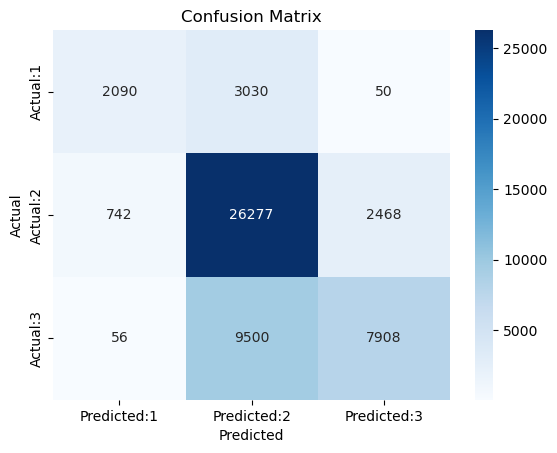

              precision    recall  f1-score   support

           1       0.72      0.40      0.52      5170
           2       0.68      0.89      0.77     29487
           3       0.76      0.45      0.57     17464

    accuracy                           0.70     52121
   macro avg       0.72      0.58      0.62     52121
weighted avg       0.71      0.70      0.68     52121

F1 Micro Averaged Score = 0.6959766696724928


In [17]:
imbalanced_best_params = random_forest_model_fitting(X_train, y_train, "imbalanced_RandomForest", grid_params=max_depth_param)

### ` Random Forest on Undersampled Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for UndersampledRandomForest: {'max_depth': 20}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


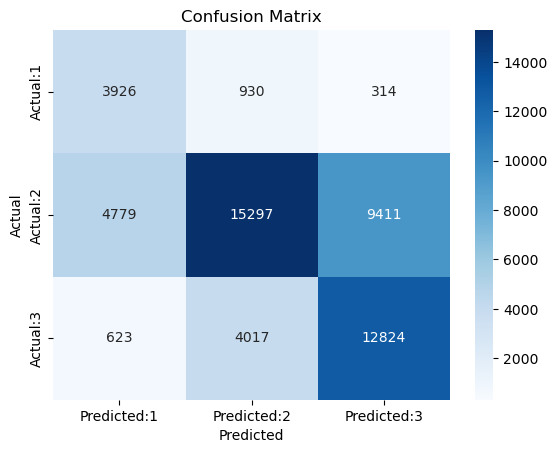

              precision    recall  f1-score   support

           1       0.42      0.76      0.54      5170
           2       0.76      0.52      0.62     29487
           3       0.57      0.73      0.64     17464

    accuracy                           0.61     52121
   macro avg       0.58      0.67      0.60     52121
weighted avg       0.66      0.61      0.62     52121

F1 Micro Averaged Score = 0.6148577348861304


In [18]:
undersampled_best_params = random_forest_model_fitting(X_train_under_sample, y_train_under_sample, "UndersampledRandomForest", grid_params=max_depth_param)

### `Random Forest on Oversampled Dataset`

In [21]:
oversampled_best_params = random_forest_model_fitting(X_train_over_sample, y_train_over_sample, "OversampledDecisionTree", grid_params=max_depth_param)

### `Random Tree Classifier on SMOTE Dataset`

In [ ]:
smote_best_params = random_forest_model_fitting(X_train_smote, y_train_smote, "SMOTEDecisionTree", grid_params=max_depth_param)

## Experiment 2: Tuning `max_features` parameter

In [22]:
max_feature_param = {
"max_features": [None, "sqrt", "log2"]
}

### ` Random Forest on Imbalanced Dataset`

In [23]:
imbalanced_best_params = random_forest_model_fitting(X_train, y_train, "imbalanced_RandomForest", grid_params=max_feature_param)

Performing GridSearchCv


KeyboardInterrupt: 

### ` Random Forest on Undersampled Dataset`

In [ ]:
undersampled_best_params = random_forest_model_fitting(X_train_under_sample, y_train_under_sample, "UndersampledRandomForest", grid_params=max_feature_param)

### `Random Forest on Oversampled Dataset`

In [ ]:
oversampled_best_params = decision_tree_model_fitting(X_train_over_sample, y_train_over_sample, "OversampledDecisionTree", grid_params=max_feature_param)

### `Random Forest on SMOTE Dataset`

In [ ]:
smote_best_params = decision_tree_model_fitting(X_train_over_sample, y_train_over_sample, "OversampledDecisionTree", grid_params=max_feature_param)